# Overview

In this notebook we will calculate the height of objects in an image.

To do so we are going to use the **Single-view geometry**.

## Single View Metrology: Algorithm

The whole single view geometry algorithm is composed by the next 7 steps, for the purpose of this notebook we are going to only follow the three first ones:

1. Select parallel lines on the image in the axis X,Y,Z
2. Compute the vanishing points on X,Y,Z (vanishing points)
3. Specify the real points on the base plane (X,Y,0)
4. ~~Specify the height reference (define the scale)~~
5. ~~Compute the 3D positions at some points (planes)~~
6. ~~Extract textures by rectifying the perspective projection~~
7. ~~Reconstruction in a virtual model~~

## Calculating the height

The computation of the height of an object could be done with the next equation:

$$\alpha Z_i = - \frac{|| b_i \times t_i||}{(l \cdot b_i) \cdot ||v_z \times t_i||}$$

![Variable information](metrology.png)

The variables in the previous image has the next meanings:
* $x$: Object to compute the height.
* $r$: Reference object of which we know the height.
* $b_x$: "Bottom point" of $x$.
* $t_x$: "Top point" of $x$.
* $b_r$: "Bottom point" of $r$.
* $t_r$: "Top point" of $r$.
* $v_x$, $v_y$, $v_z$: "Vanishing points" from three axis.
* $l$: Vanishing line (Straight line joining $v_x$, $v_y$).
* $v_z$: Two vertical lines vanishing point.

Solve the next equation for $i=r$ to discover the value of $\alpha$ (We know that $Z_r$ = 202 cm) and next solve the equation for $i=x$ to discover the height of the $x$ object.
$$\alpha Z_i = - \frac{|| b_i \times t_i||}{(l \cdot b_i) \cdot ||v_z \times t_i||}$$


## Import the libraries

Firt of all we're gonna import the libraries used to find the calculate the height
of an object. We're gonna mainly use openCV and matplotlib and a module containing
helper functions.

In [1]:
from copy import deepcopy

import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA

import common

## Read the data

We read the image from the file.

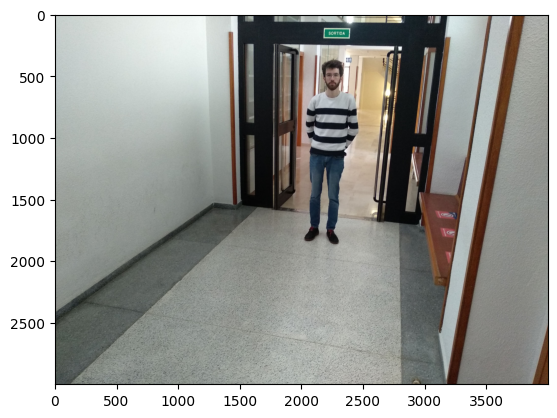

In [2]:
img = cv2.imread("passadis.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)

# Algorithm

## Step 1: Select parallel lines

1. **Select parallel lines on the image in the axis X,Y,Z**
2. Compute the vanishing points on X,Y,Z (vanishing points)
3. Specify the real points on the base plane (X,Y,0)
4. ~~Specify the height reference (define the scale)~~
5. ~~Compute the 3D positions at some points (planes)~~
6. ~~Extract textures by rectifying the perspective projection~~
7. ~~Reconstruction in a virtual model~~

In [3]:
# Vertical lines
y_lines = [
    [(718, 2409), (2804, 2782)], 
    [(1327, 1874), (2799, 2057)]
]

# Horizontal lines
x_lines = [
    [(2808, 2689), (2796, 2112)], 
    [(795, 2361), (1235, 1952)]
]

# Depth lines (Altura objectes)
z_lines = [
    [(1792, 1585), (1788, 247)], 
    [(2176, 1785), (2251, 379)]
]

We show the lines over the image. We define a different color for each axis.

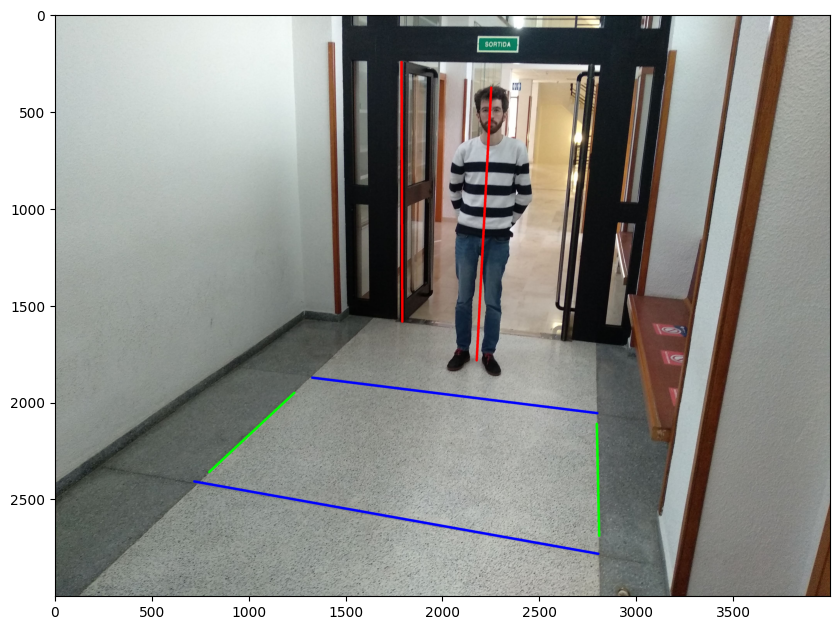

In [4]:
img_lines = np.copy(img)
color = (0, 255, 0)
thickness = 12
for init_point, final_point in x_lines:
    cv2.line(img_lines, init_point , final_point, color, thickness)

color = (0, 0, 255)
for init_point, final_point in y_lines:
    cv2.line(img_lines, init_point , final_point, color, thickness)

color = (255, 0, 0)
for init_point, final_point in z_lines:
    cv2.line(img_lines, init_point , final_point, color, thickness)

plt.figure(figsize=(10, 10))
plt.imshow(img_lines)
plt.show()

### Convert to homogenous coordinates

Now we have a set of lines. We need to convert the coordinates of each line to
[homogenous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates). Firstly we define a function to update the value of the
lines to homogenous using the function already defined on the ``common`` module

In [5]:
def to_homogeneous(lines, img):
    """ Converts all the lines passed as parameter to homogenous.

    Args:
        lines:
        shape:

    Returns:

    """

    out_lines = deepcopy(lines)
    for line in out_lines:
        point1, point2 = line

        line[0] = list(common.geometry.convert(point1, img, common.geometry.ORG_2_HMG))
        line[1] = list(common.geometry.convert(point2, img, common.geometry.ORG_2_HMG))

    return out_lines

In [6]:
x_lines_hom = to_homogeneous(x_lines, img)
y_lines_hom = to_homogeneous(y_lines, img)
z_lines_hom = to_homogeneous(z_lines, img)

In [7]:
x_lines_hom

[[[808.0, 1189.0, 1750.0], [796.0, 612.0, 1750.0]],
 [[-1205.0, 861.0, 1750.0], [-765.0, 452.0, 1750.0]]]

In [8]:
x_lines

[[(2808, 2689), (2796, 2112)], [(795, 2361), (1235, 1952)]]

## Step 2: Compute vanishing points

1. Select parallel lines on the image in the axis X,Y,Z
2. **Compute the vanishing points on X,Y,Z (vanishing points)**
3. Specify the real points on the base plane (X,Y,0)
4. ~~Specify the height reference (define the scale)~~
5. ~~Compute the 3D positions at some points (planes)~~
6. ~~Extract textures by rectifying the perspective projection~~
7. ~~Reconstruction in a virtual model~~

Once we have the homogenous coordinates we can calculate the vanishing points using them.
To do so we have to follow the next equation:

$$v_p=(p_1 \times q_1) \times (p_2 \times q_2)$$

We need to apply this equation to each axis. To calculate the cross product
we use the [``np.cross()``](https://numpy.org/doc/stable/reference/generated/numpy.cross.html) function.

In [10]:
def vp(p1,q1,p2,q2):
    return np.cross(np.cross(p1,q1),np.cross(p2,q2))


In [11]:
vp_x = vp(x_lines_hom[0][0], x_lines_hom[0][1], x_lines_hom[1][0], x_lines_hom[1][1])
vp_y = vp(y_lines_hom[0][0], y_lines_hom[0][1], y_lines_hom[1][0], y_lines_hom[1][1])
vp_z = vp(z_lines_hom[0][0], z_lines_hom[0][1], z_lines_hom[1][0], z_lines_hom[1][1])


In [12]:
vp_x

array([ 3.45605855e+11, -4.38598330e+11,  7.92538250e+11])

In [13]:
# After we get the vanishing points we scale them to have the last element equals to 1
vp_x = vp_x / vp_x[2]
vp_y = vp_y / vp_y[2]
vp_z = vp_z / vp_z[2]

In [14]:
vp_x

array([ 0.43607467, -0.55340967,  1.        ])

## Step 3: Transform to real coordinates

1. Select parallel lines on the image in the axis X,Y,Z
2. Compute the vanishing points on X,Y,Z (vanishing points)
3. **Specify the real points on the base plane (X,Y,0)**
4. ~~Specify the height reference (define the scale)~~
5. ~~Compute the 3D positions at some points (planes)~~
6. ~~Extract textures by rectifying the perspective projection~~
7. ~~Reconstruction in a virtual model~~

Draw the vanishing points onto the image, transforming the homogeneous coordinates to the original ones.

(2263, 1031) (-10989, 904) (1312, 9091)


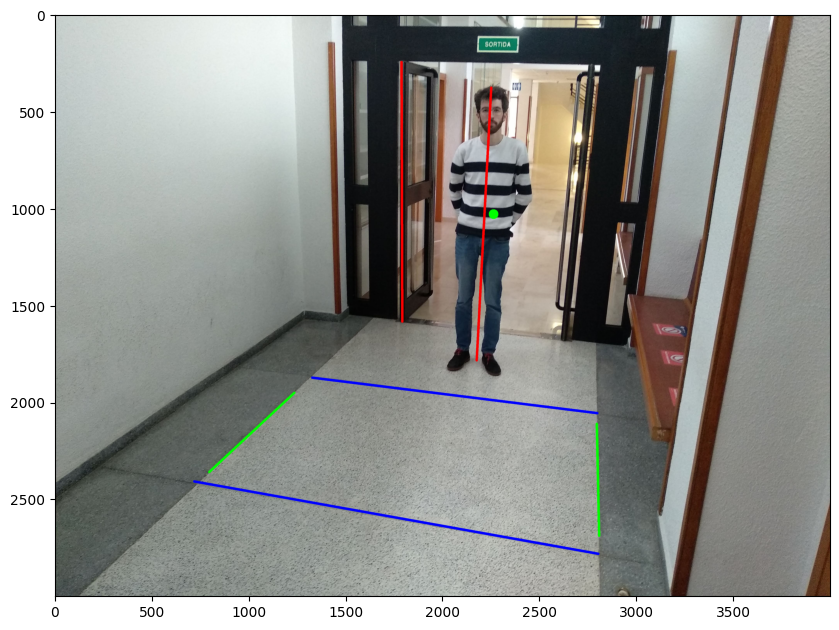

In [15]:
vp_x_org = common.geometry.convert(vp_x, img, common.geometry.HMG_2_ORG)

cv2.circle(img_lines, tuple(vp_x_org), 25, (0,255,0), -1)

vp_y_org = common.geometry.convert(vp_y, img, common.geometry.HMG_2_ORG)

cv2.circle(img_lines, tuple(vp_y_org), 25, (0, 0, 255), -1)

vp_z_org = common.geometry.convert(vp_z, img, common.geometry.HMG_2_ORG)

cv2.circle(img_lines, tuple(vp_z_org), 25, (255, 0, 0), -1)


plt.figure(figsize=(10, 10))
plt.imshow(img_lines)
print(vp_x_org, vp_y_org, vp_z_org)

In [18]:
vp_x_org

(2263, 1031)

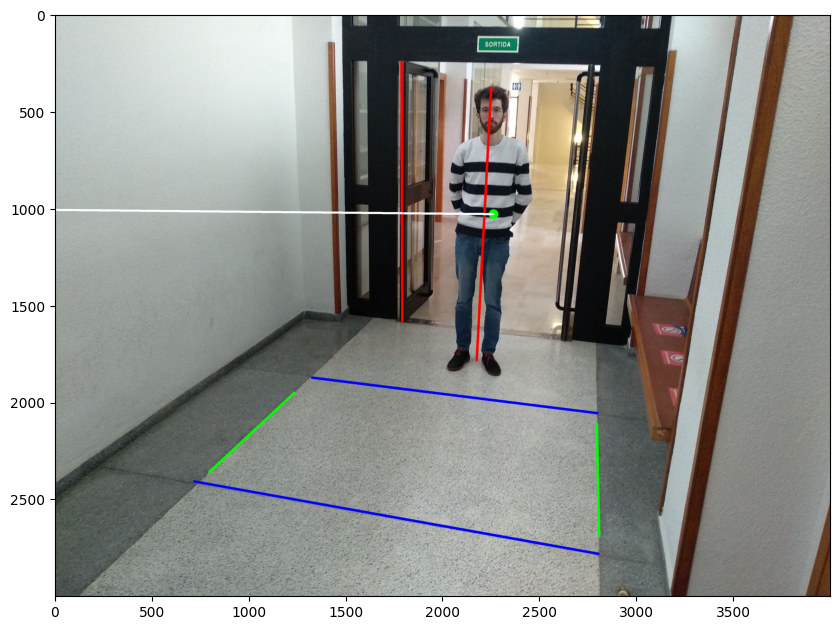

In [16]:
cv2.line(img_lines, vp_x_org, vp_y_org, (255, 255, 255), 10)

plt.figure(figsize=(10, 10))
plt.imshow(img_lines);

Once we have the vanishing point from the horizontal and vertical axis we can get the vanishing line doing the cross product between the $vp_x$ and the $vp_y$ (in homogeneous coordinates).

In [17]:
l = np.cross(vp_x,vp_y)
l

array([ 0.07233679, -7.57302975, -4.22253212])

After we get the vanishing points we scale them to have the last element equals 1

## Step 4: Compute the height

Once we have the vanishing point we can get the height of an object of the image. To do so we need a known height of some object of the image. The calculation is based on the next equation

$$\alpha Z_i = - \frac{|| b_i \times t_i||}{(l \cdot b_i) \cdot ||v_z \times t_i||}$$

![Variable information](metrology.png)


For the aim to get the value of $Z_x$ from the previous equation we need to know the value of $\alpha$. As we know that the door is 202 cm high, we have the $Z_r$ equation, and then we can obtain the unique unknown value ($\alpha$):

$$\alpha = - \frac{\frac{|| b_r \times t_r||}{(l \cdot b_r) \cdot ||v_z \times t_r||}}{202}$$

See [LA.norm documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

Remember that reference Z line is in z_lines_hom[0] and the other in z_lines_hom[1].

In [19]:
from numpy import linalg as LA

Extracting the lines for reference object (door)

In [20]:
br, tr = z_lines_hom[0]  # Reference Z line for the door
vz = vp_z                # Vanishing point for Z direction

Calculation for alpha

In [21]:
first = LA.norm(np.cross(br, tr))
second = np.dot(l, br)
third = LA.norm(np.cross(vz, tr))
fourth = second * third
g = first / fourth
alpha = -(g / 202)

print("Alpha:", alpha)

Alpha: 0.00017261032575033232


Once we have the $\alpha$ value, the computation of $Z_x$ is as follows:
$$ Z_x = - \frac{\frac{|| b_x \times t_x||}{(l \cdot b_x) \cdot ||v_z \times t_x||}}{ \alpha} $$

Calculation for Zx

In [23]:
# Extracting the lines for the target object
bx, tx = z_lines_hom[1] 

In [24]:
first_x = LA.norm(np.cross(bx, tx))
second_x = np.dot(l, bx)
third_x = LA.norm(np.cross(vz, tx))
fourth_x = second_x * third_x
g_x = first_x / fourth_x
z_x = -(g_x / alpha)

print("Height Zx of the target object:", z_x)

Height Zx of the target object: 182.04657039990644
